# Анализ бизнес-показателей приложения Procrastinate Pro+.

**Объект исследования**: Развлекательное приложение Procrastinate Pro+.


**Цель исследования**: Разобраться в причинах убытков и помочь компании выйти в плюс. 

Заранее нам известны следующие данные за период  с 1 мая по 27 октября 2019 года:

    -Лог сервера с данными об их посещениях,
    -Выгрузка их покупок за этот период,
    -Рекламные расходы.
    
Данные, которые нужно изучить:

    -Откуда приходят пользователи и какими устройствами они пользуются,
    -Сколько стоит привлечение пользователей из различных рекламных каналов;
    -Сколько денег приносит каждый клиент,
    -Когда расходы на привлечение клиента окупаются,
    -Какие факторы мешают привлечению клиентов.
    
    
План анализа:

    1. Выгрузить данные
    2. Предобработка данных
        -Изучение типов данных столбцов
        -Проверка на дубликаты и пропуски
    3.Создание функций
        -Функции для расчета конверсии, удержания и построения графиков
    4. Исследование
        -Установить горизонт и момент анализа
        -Создадим таблицу и визуализируем пользователей в разрезе по странам, устройствам и каналам привлечения
    5. Макретинг
        -Определим общую сумму затрат на маркетинг 
        -Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC)
        -Построим визуализацию динамики изменения расходов во времени
        -Проанализируем окупаемость рекламы
        -Построим графики конверсии, удержания, так же LTV,ROI
    6. Общий вывод

**ЗАГРУЗКА ДАННЫХ**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
visits = pd.read_csv('/datasets/visits_info.csv')
orders = pd.read_csv('/datasets/orders_info.csv')
costs = pd.read_csv('/datasets/costs_info.csv')

In [3]:
display(visits.head(10))
display(orders.head(10))
display(costs.head(10))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


    Наименования столбцов нужно привести к нижнему регистру, так же наименования, состоящие из двух слов разделить нижним подчеркиванием.

**ПРЕДОБРАБОТКА ДАННЫХ**

In [4]:
#Приводим все столбцы к нижнему регистру
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

In [5]:
#Заменяем пробелы на подчеркивания
visits.columns = visits.columns.str.replace(' ', '_')
orders.columns = orders.columns.str.replace(' ', '_')

In [6]:
#Проверяем 
display(visits.columns)
display(orders.columns)
display(costs.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

Index(['dt', 'channel', 'costs'], dtype='object')

In [7]:
#смотрим общую информацию и тип данных
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


     Начало и конец сессии нужно привести в тип datetime

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


     Столбец Event Dt сессии нужно привести в тип datetime

In [9]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


     Столбец с датой приведем в тип datetime

In [10]:
#Столбцы с датами приводим в нужный тип
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [11]:
#проверяем на наличие пропусков
display(visits.isna().sum())
display(costs.isna().sum())
display(orders.isna().sum())

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

    Пропусков нет - идем дальше!

In [12]:
#Смотрим есть ли дубликаты в таблицах
display(visits.duplicated().sum())
display(orders.duplicated().sum())
display(costs.duplicated().sum())

0

0

0

    Дубликатов нет, можем идти дальше

**СОЗДАНИЕ ФУНКЦИЙ**

 **Функции для вычисления значений метрик**

- Создадим фунцию для профилей пользователей **get_profiles()**

In [13]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
# объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [14]:
profiles = get_profiles(visits, orders, costs)
profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


- Создадим фунцию для расчета удеражания **get_retention()**

In [15]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

- Создадим функцию для подсчета конверсии **get_conversion()**

In [16]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

- Создадим функцию для расчета LTV и ROI **get_ltv()**

In [17]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

**Функции для построения графиков**

- Создадим функцию для сглаживания данных **filter_data()**

In [18]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

- Создаем функцию для построения графика удержания **plot_retention()**

In [19]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

- Создаем функцию для визуализации конверсии **plot_conversion()**

In [20]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


- Создаем функции для визуализации LTV и ROI **plot_ltv_roi()**

In [21]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))
    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Исследовательский анализ данных



    Известны данные, привлеченных пользователей с 1 мая по 27 октября 2019 года.
    В задании условие, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.
    Так как предоставленны данные по 27 октября 2019 года, возьмем эту дату.
    Определим минимальную и максимальную даты привлечения пользователей.


In [22]:
# момент анализа
observation_date = profiles['dt'].max() 
#горизонт анализа 
analysis_horizon = 14  # горизонт анализа

# считаем минимальную привлечения
min_analysis_date = profiles['dt'].min()

# считаем максимальную дату привлечения
max_analysis_date =  observation_date - timedelta(days=analysis_horizon - 1) 

print(f'Минимальная дата привлечения пользователей: {min_analysis_date}')
print(f'Максимальная дата привлечения пользователей: {max_analysis_date}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-14


- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [23]:
# создаем таблицу по странам с информацией о пользователях
countries = (profiles
           .pivot_table(
                        index='region',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
          )
countries['payer_share'] = (countries.payer / (countries.not_payer + countries.payer) * 100).round(2)
countries

payer,not_payer,payer,payer_share
region,,,
United States,93100,6902,6.90
UK,16875,700,3.98
France,16787,663,3.80
Germany,14365,616,4.11


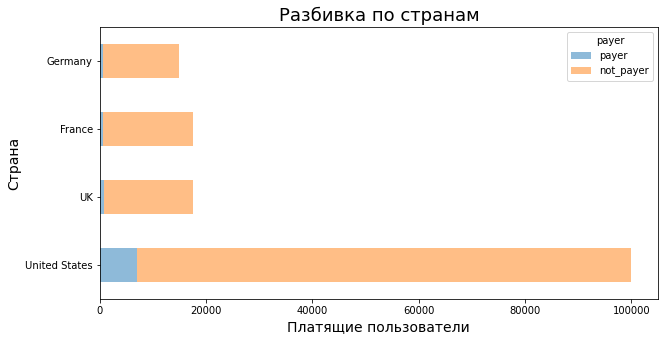

In [24]:
# визуализация столбца payer
fig, ax = plt.subplots(figsize=(18, 5))
countries[['payer', 'not_payer']].plot(kind = 'barh', figsize = (10,5), stacked=True, ax=ax, alpha = 0.5);
plt.xlabel("Платящие пользователи", fontsize = 14);
plt.ylabel("Страна", fontsize = 14);
plt.title(r'Разбивка по странам', fontsize = 18);

    По полученному графику, можем увидеть, что количество платящих пользователей, так и всех в США сильно выделяется на фоне остальных стран,  имея наибольшее их количество. В остальных странах количество примерно одинаковое. 

- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [25]:
# таблица по устройствам
device = (profiles
         .pivot_table(
                      index='device',
                      columns='payer',
                      values='user_id',
                      aggfunc='count')
          .rename(columns={True: 'payer', False: 'not_payer'}))
          
device['payer_share'] = (device.payer / (device.not_payer + device.payer) * 100).round(2)
device

payer,not_payer,payer,payer_share
device,,,
Android,32982,2050,5.85
Mac,28130,1912,6.36
PC,28918,1537,5.05
iPhone,51097,3382,6.21


    По полученной таблице видим, что обладатели айфонов пользуются приложением в большей степени, в то время как разница между айфоном и другими устройствами около 20 тысяч.

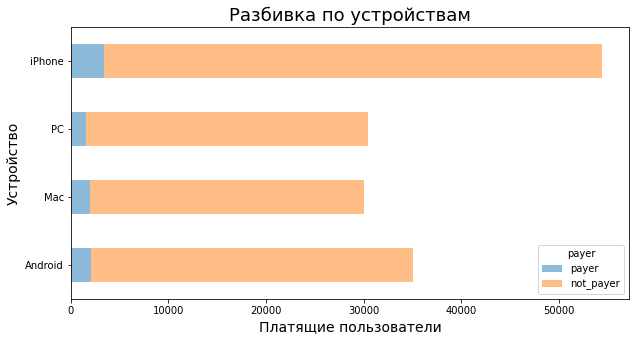

In [26]:
# визуализация столбца payer
fig, ax = plt.subplots(figsize=(18, 5))
device[['payer', 'not_payer']].plot(kind = 'barh', figsize = (10,5), stacked=True, ax=ax, alpha = 0.5);
plt.xlabel("Платящие пользователи", fontsize = 14);
plt.ylabel("Устройство", fontsize = 14);
plt.title(r'Разбивка по устройствам', fontsize = 18);

    По графику можем определить, что большее количество платящих пользователей имеют устройства iphone. 

- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [27]:
channel =  (profiles
           .pivot_table(
                        index='channel',
                        columns='payer',
                        values='user_id',
                        aggfunc='count')
           .rename(columns={True: 'payer', False: 'not_payer'})
           .sort_values(by='payer', ascending=False)
          )
channel['payer_conv'] = (channel.payer / (channel.not_payer + channel.payer) * 100).round(2)
channel


payer,not_payer,payer,payer_conv
channel,,,
FaceBoom,25587,3557,12.20
TipTop,17683,1878,9.60
organic,55279,1160,2.06
WahooNetBanner,8100,453,5.30
AdNonSense,3440,440,11.34
RocketSuperAds,4096,352,7.91
LeapBob,8291,262,3.06
OppleCreativeMedia,8372,233,2.71
lambdaMediaAds,1924,225,10.47


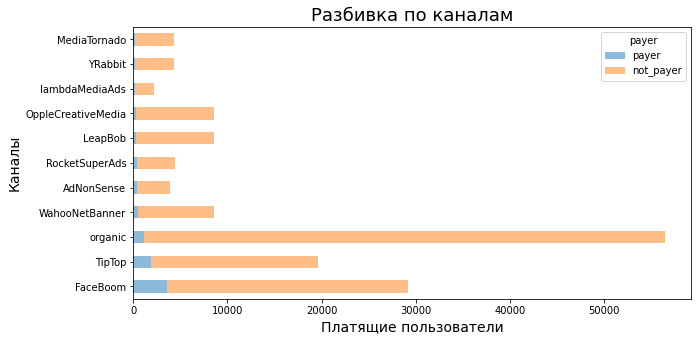

In [28]:
# визуализация столбца payer
fig, ax = plt.subplots(figsize=(18, 5))
channel[['payer', 'not_payer']].plot(kind = 'barh', figsize = (10,5), stacked=True, ax=ax, alpha = 0.5);
plt.xlabel("Платящие пользователи", fontsize = 14);
plt.ylabel("Каналы", fontsize = 14);
plt.title(r'Разбивка по каналам', fontsize = 18);

    Большая часть всех пользователей приходится на органичных, но именно платящих больше у каналов FaceBoom и TipTop.
    По полученным данным коверсии, делаем вывод, что большое количество привлеченных пользователей у каналов - FaceBoom, AdNonSense, lambdaMediaAds	и TipTop. 

# Маркетинг



- Найдем сумму общих расходов на маркетинг по всем каналам.

In [29]:
print(f'Общие растраты на рекламу: {costs.costs.sum().round()}')

Общие растраты на рекламу: 105497.0


In [30]:
costs.pivot_table(index='channel', values='costs', aggfunc='sum').sort_values(by='costs', ascending=True)

,costs
channel,
YRabbit,944.22
MediaTornado,954.48
lambdaMediaAds,1557.60
LeapBob,1797.60
RocketSuperAds,1833.00
OppleCreativeMedia,2151.25
AdNonSense,3911.25
WahooNetBanner,5151.00
FaceBoom,32445.60


- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.

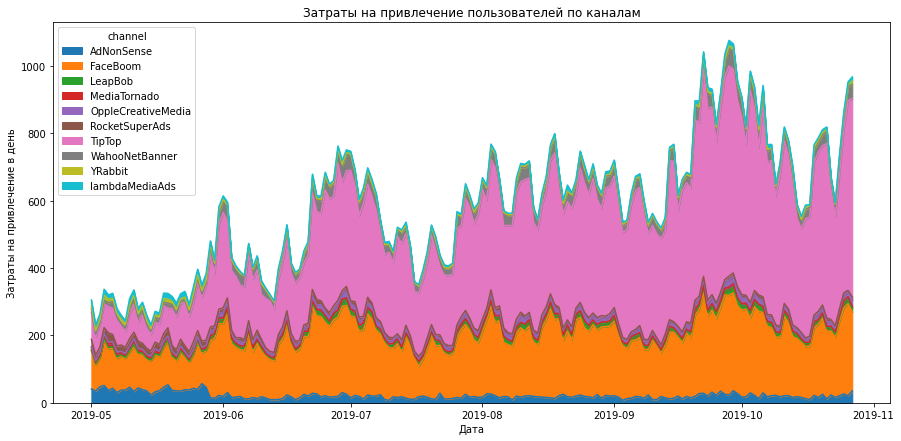

In [31]:
#визуализация по дням
fig, ax = plt.subplots(figsize=(15, 7))
costs.pivot_table(index=costs.dt, values='costs', aggfunc='sum', columns='channel').plot.area(ax=ax, stacked=True)
ax.set_title('Затраты на привлечение пользователей по каналам')
ax.set_ylabel('Затраты на привлечение в день')
ax.set_xlabel('Дата');

 - Построим графики динамики изменения расходов по неделям и месяцам

In [32]:
#создаем столбец с неделей
costs['week'] = pd.to_datetime(costs['dt']).dt.week

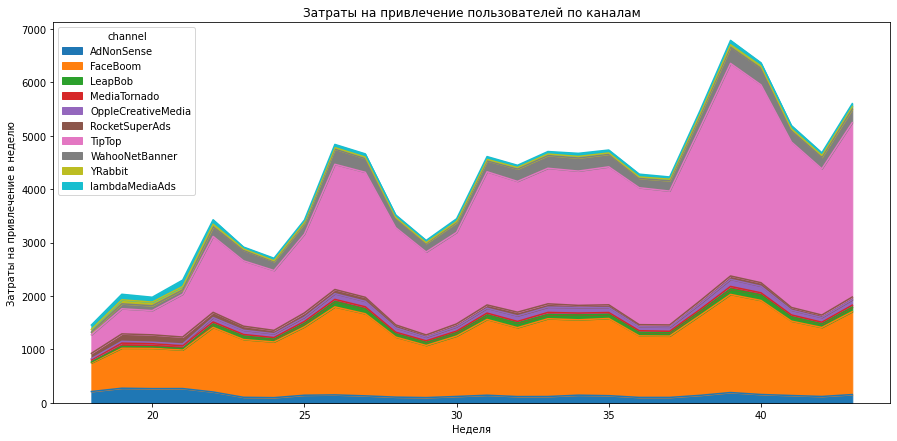

In [33]:
#строим визуализацию по месяцу
fig, ax = plt.subplots(figsize=(15, 7))
costs.pivot_table(index='week', values='costs', aggfunc='sum', columns='channel').plot.area(ax=ax, stacked=True)
ax.set_title('Затраты на привлечение пользователей по каналам')
ax.set_ylabel('Затраты на привлечение в неделю')
ax.set_xlabel('Неделя');

    В разрезе по неделям каналы - lambdaMediaAds, YRabbit, WahooNetBanner и TipTop, имеют резкие рост и падения, но в общем с первой по последнюю недели затраты выросли. Другие каналы имеют более стабильные затраты.

In [34]:
#создаем столбец с месяцем
costs['month'] = pd.to_datetime(costs['dt']).dt.month

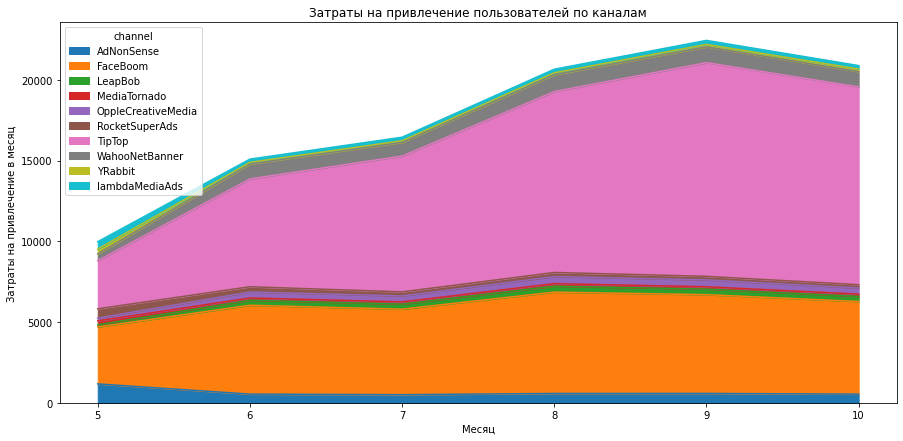

In [35]:
#строим визуализацию по месяцу
fig, ax = plt.subplots(figsize=(15, 7))
costs.pivot_table(index='month', values='costs', aggfunc='sum', columns='channel').plot.area(ax=ax, stacked=True)
ax.set_title('Затраты на привлечение пользователей по каналам')
ax.set_ylabel('Затраты на привлечение в месяц')
ax.set_xlabel('Месяц');

    Самые высокие затраты имеют каналы TipTop, YRabbit, lambdaMediaAds
    Organic не затрачивается на привлечение пользователей.
    
    В разрезе по месяцу, можно наблюдать, что каналы - lambdaMediaAds, YRabbit, WahooNetBanner и TipTop, затраты с каждым месяцем идут в рост, в то время как у других каналов затраты остаются стабильными.

- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [36]:
cac_costs = profiles.pivot_table(index='channel',  values='acquisition_cost', aggfunc='mean') \
.rename(columns={'acquisition_cost': 'cac'})
display(cac_costs.sort_values(by='cac', ascending=False))

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


    Сумма инвестиций в рекламу дороже всего обходится для TipTop, для канала organic сумма инвестиций равно нулю, то есть ничего не стоит.

- Далее визуализируем это для наглядности.

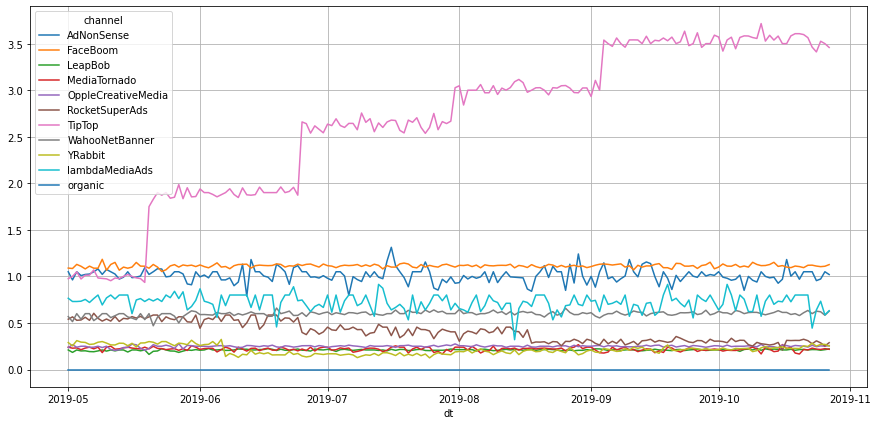

In [37]:
profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean').plot(grid=True, figsize=(15, 7));

    Визуально можем наблюдать,TipTop имеет наибольшие затраты на рекламу и увеличивает их каждый месяц. 
    Остальные каналы имеют стабильные расходы, у органических каналов они равны нулю.

# Окупаемость рекламы



- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [38]:
# удалим строку с каналом organic
profiles = profiles.query('channel != "organic"')

- Удаляем канал органик, так как инвестиции его рекламы равны нулю.

In [39]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, analysis_horizon)
ltv_grouped

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,86138,0.344835,0.435825,0.503889,0.560611,0.611611,0.654576,0.694741,0.730661,0.765474,0.797583,0.826827,0.852804,0.878797,0.903117


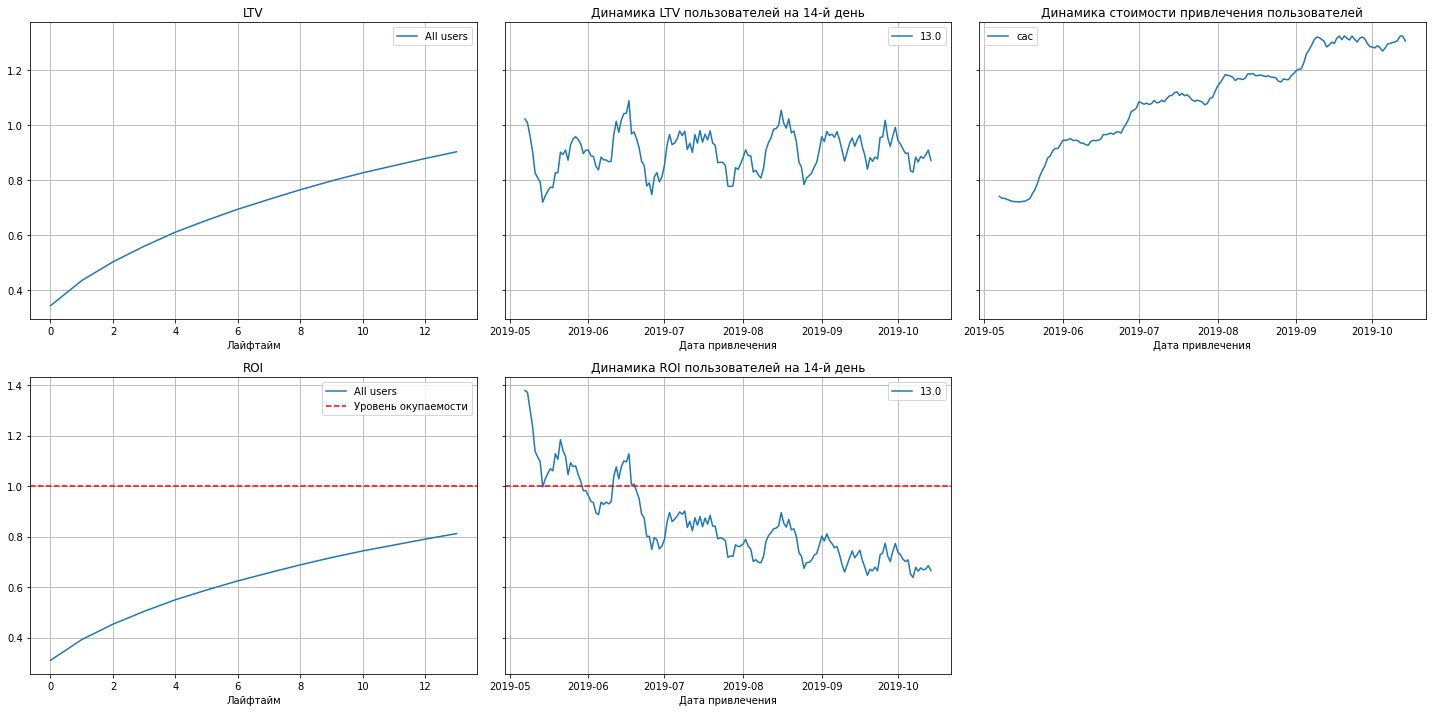

In [40]:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, analysis_horizon)

  По графикам можно сделать такие выводы: 
   
    Начиная с июня, пользователи перестают окупаться в двухнедельном лайфтайме, возможно, что-то идет не так.
    
    САС растет, получается рекламный бюджет увеличивается.
    
    Реклама не окупается. ROI чуть выше 80%.


- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

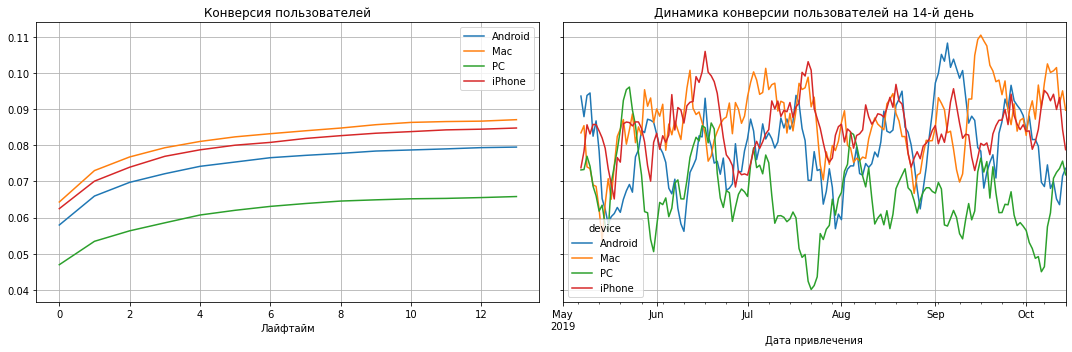

In [41]:
# смотрим коверсию в разбивке по устройствам
dimensions=['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, 14, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, 14)

    Пользователи Mac и iPhone конвертируются хорошо, практически с одинковой динамикой.
    Пользователи PC конвертируются хуже остальных.

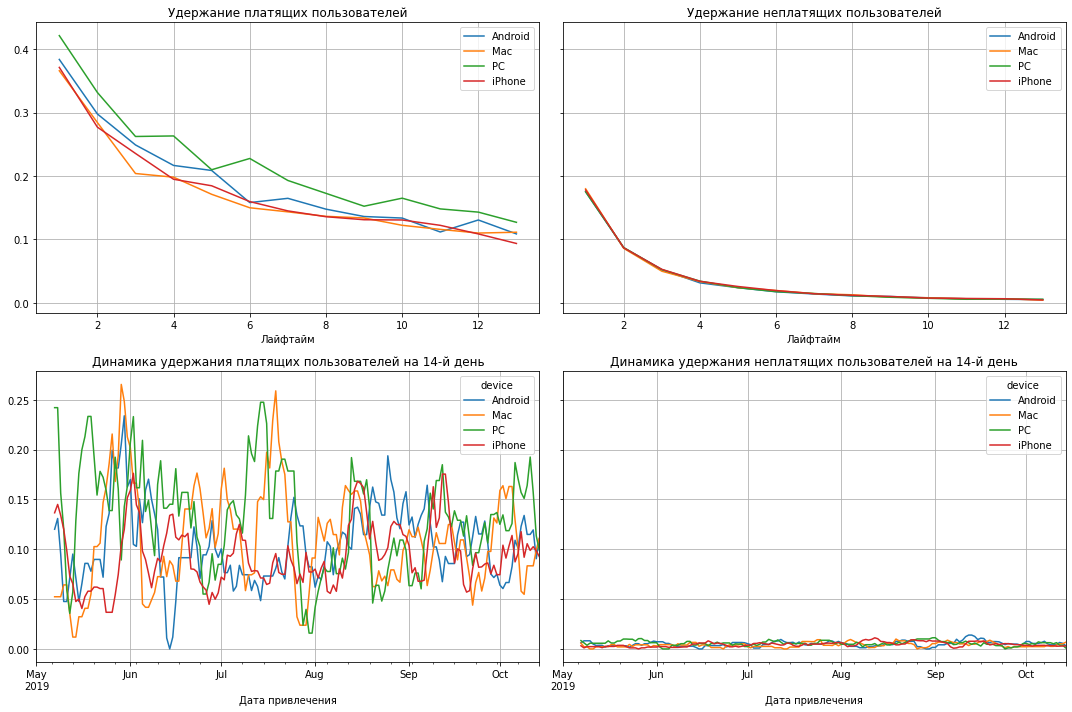

In [42]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, 14, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, 14)

    Пользователи всех устройств удерживаются плохо, график удержания платящих пользователей плавно идет на спад
    Удержание неплатящих пользователей резко стремится к нулю, настолько, что на 14-й день показатель уже на нуле.

- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

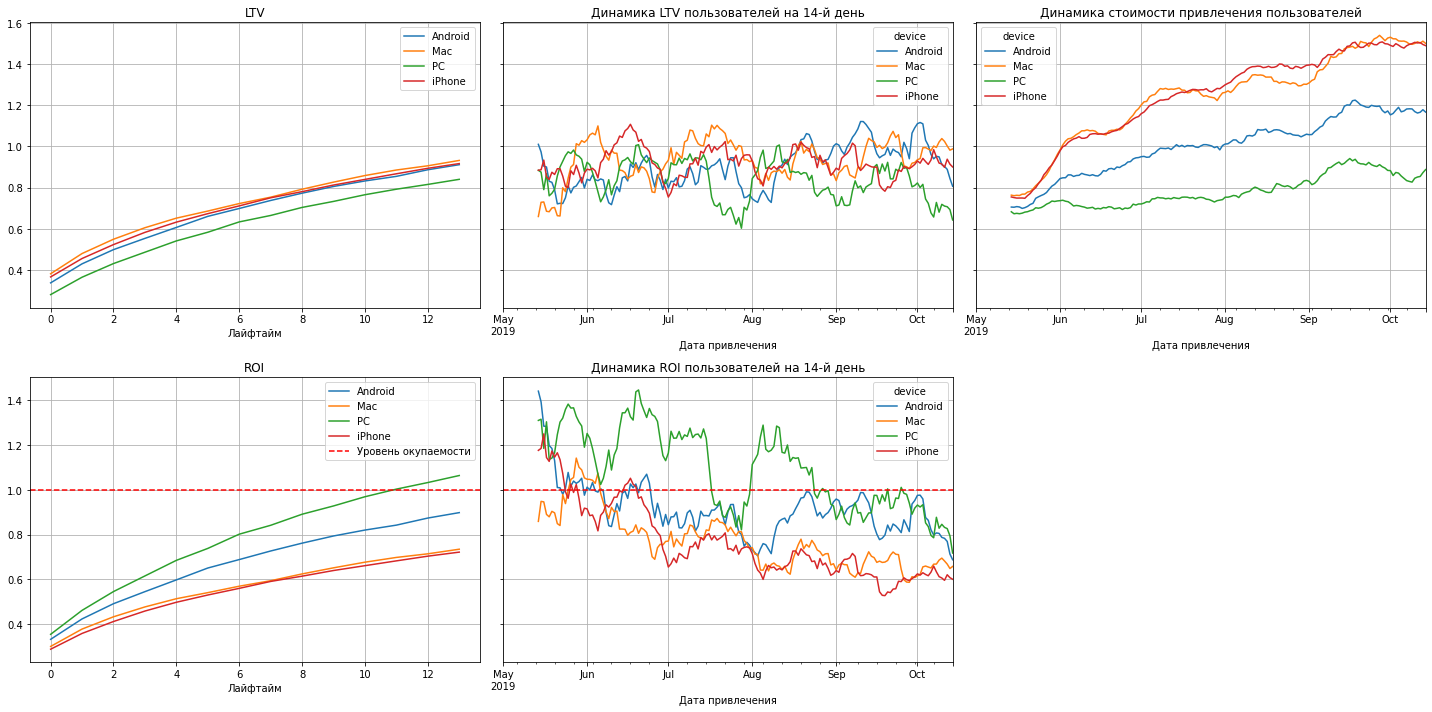

In [43]:
# смотрим окупаемость с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, 14, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
)

    Динамика привлечения пользователей заметно увеливается на всех устройсвтах.
    Пользователи PC стабильно окупаются, Android окупается, но в некоторые месяцы проседает. 
    Пользователи iPhone и Mac не окупаются, но тратят намного больше средств на рекламу, но также можем заметить, что чем   больше они затрачиваются на рекламу, тем меньше они начинают окупаться.

- Проанализируем окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

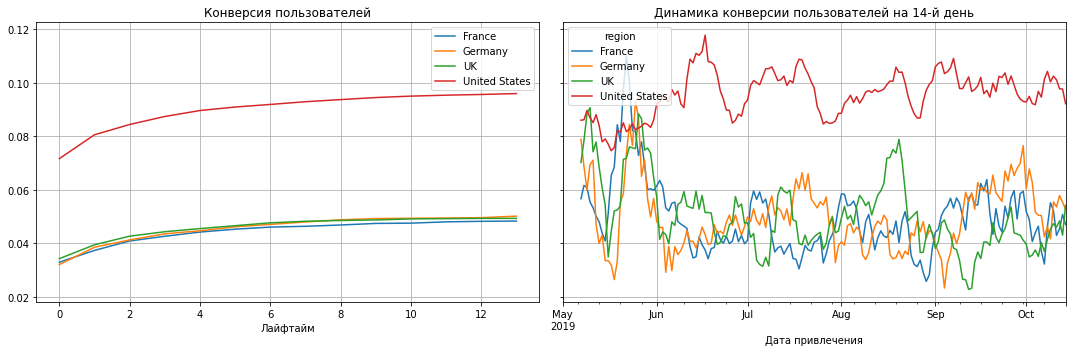

In [44]:
# смотрим коверсию в разбивке по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, 14, dimensions=['region'])

plot_conversion(conversion_grouped, conversion_history, 14)

    У США самая высокая конверсия, среди остальных стран, которая сильно выделяется на их фоне.
    Так же наблюдаем у США самую высокую динамику на 14-й день, остальные страны примерно с одинковыми показателями.
    У европейских стран в мае был резкий спад конверсии на 14-й день, то тут же произошел резкий скачок в конце мая, после  чего снова резкий спад в июне, далее конверсия более стабильна.

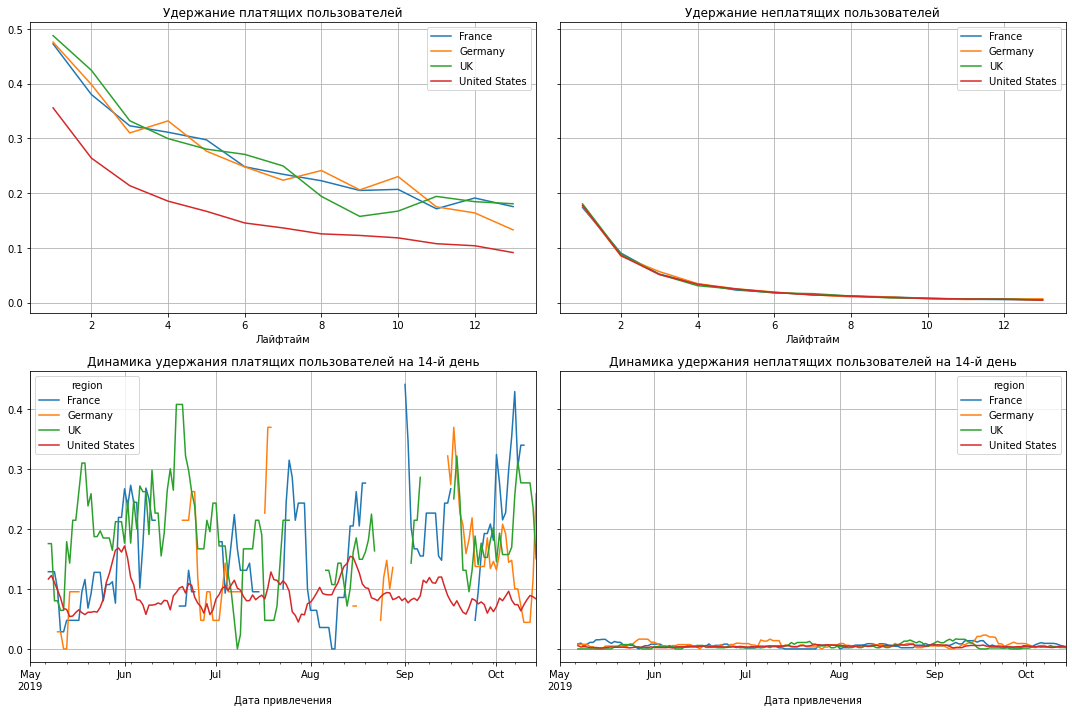

In [45]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, 14, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, 14)

    Очень извилистые кривые в графике удержания платящих пользователей у европейских стран, что говорит о нестабильности удержания. США имеет плавную линию.
    Очень интресный график удержания на 14-й день, европейские старны имеют прерывистые линии, возможно это может указывать на ошибку с оплатой в приложении. У США же более стабильная и неприрывистая линия, можем сделать вывод, что в США пользователи не сталкиваются с трудностями на шаге оплаты.

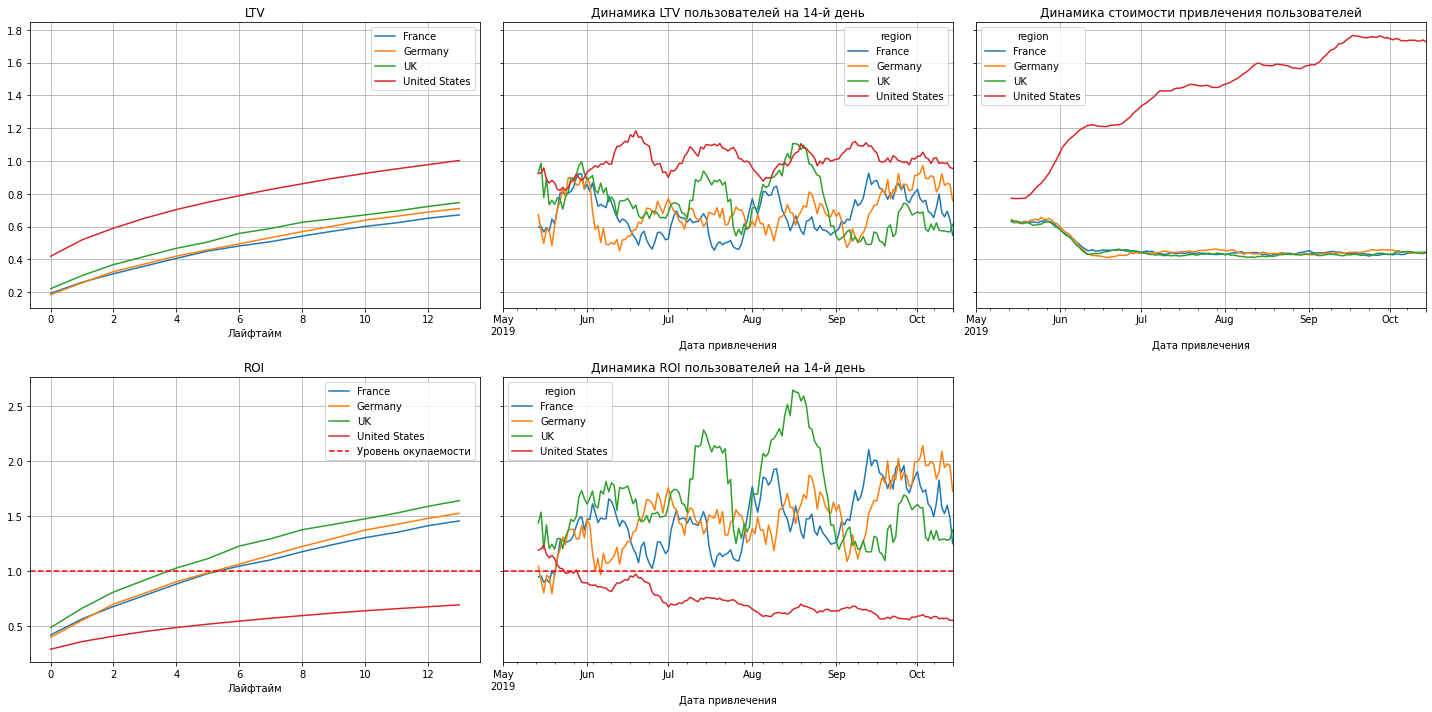

In [46]:
# смотрим окупаемость с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, 14, dimensions=['region']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
)

По разбивке по странам можем сказать что:

    - США резко увеличили расходы на рекламу, но она не окупается, несмотря на самый высоки показатель жизненной ценности пользователя.
    - В остальных странах рекалама окупается, динамика стоимости стабильна и практически одинакова
    

- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

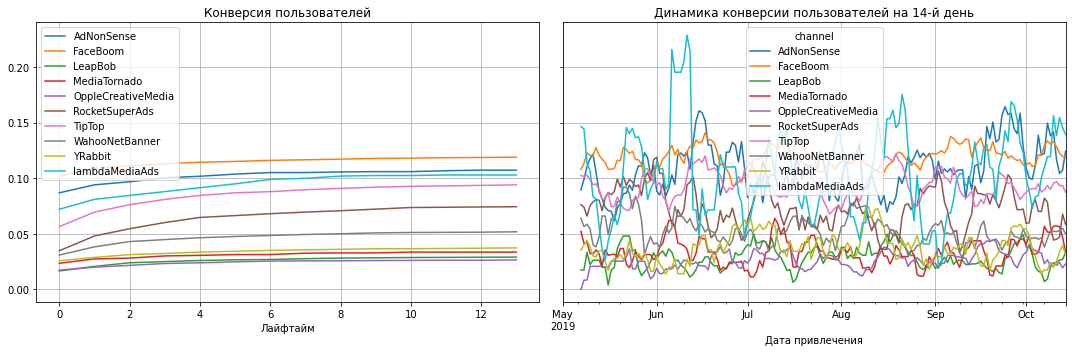

In [47]:
# смотрим коверсию в разбивке по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, 14, dimensions=['channel'])

plot_conversion(conversion_grouped, conversion_history, 14)

    Самая высокая конверсия у каналов - AdNonSense, FaceBoom, lambdaMediaAds
    По графику динамики конверсии на 14-й видим, что у канала lambdaMediaAds сильно резкие скачки спада и роста конверсии.
    Более стабильная и высокая конверсия на 14-й день у канала FaceBoom

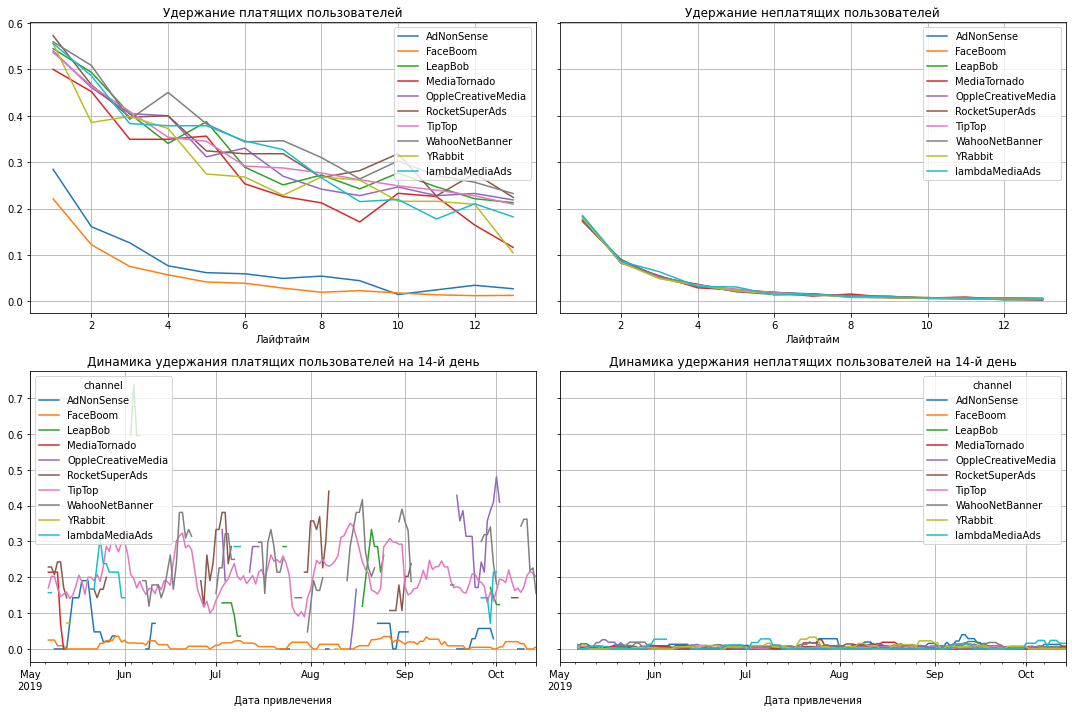

In [48]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, 14, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, 14)

    Все каналы, кроме FaceBoom и  TipTop имеют очень ломкие линии на графике удержания платящих пользователей, но при этом их удержание лучше. У FaceBoom и TipTop низкий уровень удержания.
    Так же на графике 14-го дня наблюдаем прерывистые линии у этих же каналов. Можем предположить, что они привязаны к европейским странам, так как имеют сходство в графиках.

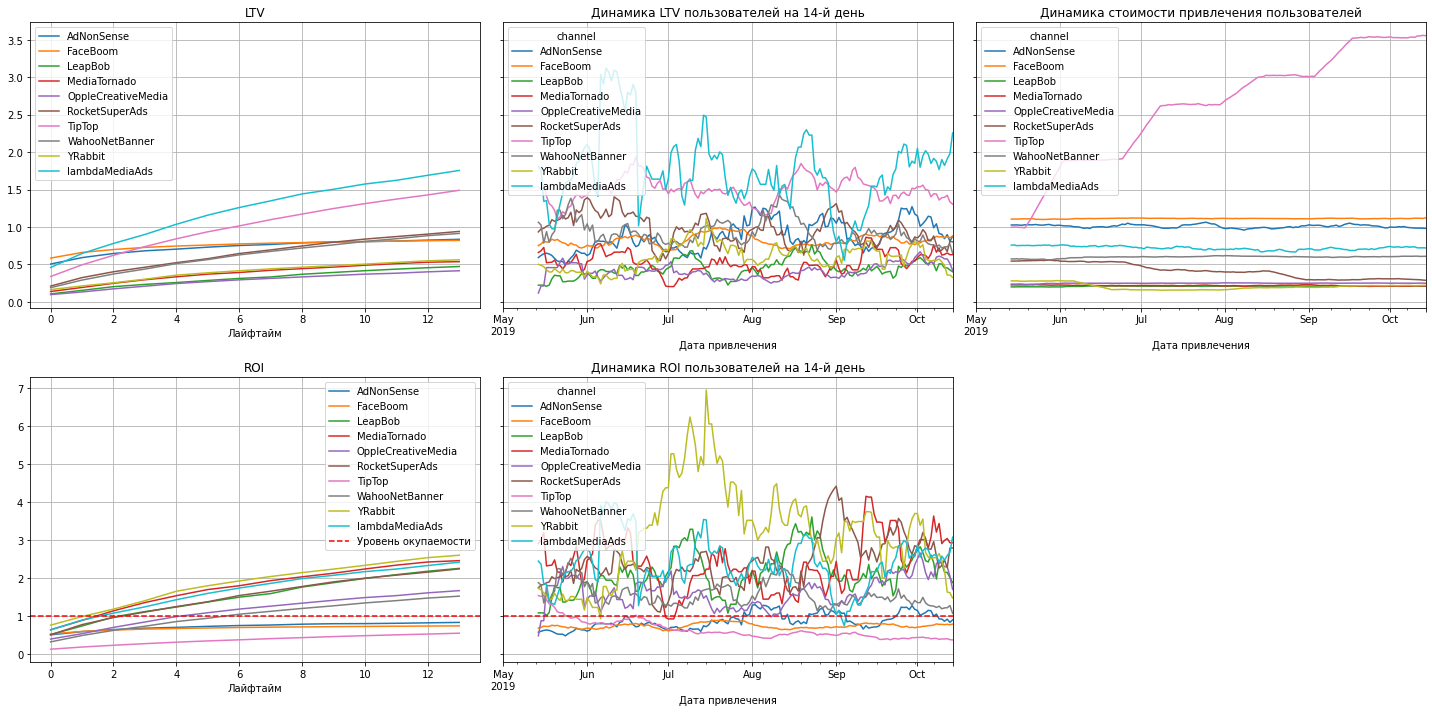

In [49]:
# смотрим окупаемость с разбивкой по каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, 14, dimensions=['channel']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14
)

    Выделим каналы, которые стабильно не окупаются - TipTop, FaceBoom, AdNonSense
    Более перспектывным кажется канал lambdaMediaAds
    Остальные каналы окупаются и имеют стабильную динамику стоимости
    В мае канал TipTop резко и намного увеличивает стоимость привлечения пользователей, реклама становится такой дорогой,   что  не позволяет окупить ее, даже при самом высоком уровне LTV среди остальных каналов.
    
    

- Посмотрим привязаны ли страны к определенным каналам привлечения

In [50]:
profiles.pivot_table(index='channel', columns='region', aggfunc={'user_id': 'count'}) \
.sort_values(by=('user_id', 'United States'), ascending=False)

user_id                              
region              France Germany      UK United States
channel                                                 
FaceBoom               NaN     NaN     NaN       29144.0
TipTop                 NaN     NaN     NaN       19561.0
RocketSuperAds         NaN     NaN     NaN        4448.0
MediaTornado           NaN     NaN     NaN        4364.0
YRabbit                NaN     NaN     NaN        4312.0
AdNonSense          1366.0  1219.0  1295.0           NaN
LeapBob             2988.0  2519.0  3046.0           NaN
OppleCreativeMedia  2991.0  2562.0  3052.0           NaN
WahooNetBanner      2971.0  2579.0  3003.0           NaN
lambdaMediaAds       742.0   649.0   758.0           NaN

    Можем заметить, что США пользуются теми самыми каналами привелчения, которые оказывают негативное влияния на окупаемость рекламы.
    Другие страны не используют эти каналы из-за чего и держат стабильность и окупаемость.

**Вывод по всей окупаемости**

     В целом, реклама не окупается ROI чуть выше 80%
     Рекламный бюджет увеличивается, по графикам можем заметить, что ROI и CAC имеют высокую корреляцию, так как с увеличением бюджета на рекламу - окупаемость становится все ниже.
     
     Предположительно, негативное влияние среди стран оказывает США, так как стабильно не окупается и динамика ее окупаемости снижается. Так же среди устройств негативное влияние оказвают пользователи Mac и iPhone, имея практически такие же    показатели как у США. Негативно сказываются каналы - TipTop и FaceBoom.
     
     Проблемы окупаемости могут быть вызваны слишком большими и не эффективными затратами на рекламу.

# Общий вывод



Объект исследования - развлекательное приложение Procrastinate Pro+

Цель исследования - выявить причины убытков и дать рекомендации

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

На основе предоставленных данных, мы провели исследования, в ходе которого выяснили что:

    - Большинство пользователей приходится на органичные каналы и США
    - Органичный канал совсем не затрачивается на рекаламу, скорее всего это причина тому, что в соотношении он имеет мало    платящих пользователей
    - Негативное влияния оказывают каналы TipTop, FaceBoom, имея наибольшие затраты на рекламу, из-за чего они и могут не окупаться
    - Канал TipTop каждый месяц увеличивает стоимость привлечения пользователей, с такой скоростью окупаемость падает вниз
    - Все страны Европы окупаются и имеют стабильную стоимость привлечения пользователей
    
Рекомендации:
- США стоит поменять каналы привлечения, отказаться от FaceBoom и TipTop
- Более перспективным для США кажется канал RocketSuperAd, так как имеет окупаемость и стабильное удержание
- Возможно, каналу organic стоит вкалдываться в рекламу, чтобы увеличить рост платящих пользователей